In [355]:
import sklearn
import scipy
import matplotlib.pyplot as plt
import chart_studio.plotly as py
import plotly.graph_objects as go
import seaborn as sns
from sklearn.metrics import classification_report,accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from pylab import rcParams
from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import StrMethodFormatter
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline

## Análise Exploratória

Principais tipos de pagamentos

In [356]:
payments = pd.read_csv('olist_order_payments_dataset.csv')

In [357]:
payments.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


In [358]:
# 2 casas decimais para melhor visualization
round(payments.describe(), 2)

,payment_sequential,payment_installments,payment_value
count,103886.00,103886.00,103886.00
mean,1.09,2.85,154.10
std,0.71,2.69,217.49
min,1.00,0.00,0.00
25%,1.00,1.00,56.79
50%,1.00,1.00,100.00
75%,1.00,4.00,171.84
max,29.00,24.00,13664.08


In [359]:
# Quantidade de compras em cada tipo de pagamentos
payment_types = payments['payment_type'].value_counts()
payment_types

credit_card    76795
boleto         19784
voucher         5775
debit_card      1529
not_defined        3
Name: payment_type, dtype: int64

Note: de acordo com os numeros acima, CREDIT CARD e a melhor forma de pagamentos, 
ja o DEBIT CARD a menos utilizada

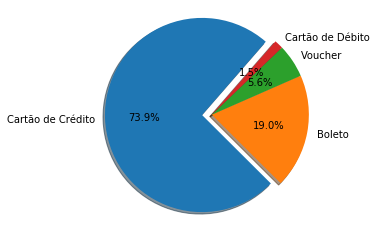

In [360]:
labels = 'Cartão de Crédito', 'Boleto', 'Voucher', 'Cartão de Débito'
sizes = [76795, 19784, 5775, 1529]
explode = (0.1, 0, 0, 0)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=49)
ax1.axis('equal')

plt.show()

PARCELAMENTO COM O CREDT CARD

In [361]:
# Compras com mais de uma parcela
inst_payments = payments[(payments['payment_type'] == 'credit_card') &
                         (payments['payment_installments'] > 1)]['order_id'].count()

In [362]:
no_installments = payments[(payments['payment_type'] == 'credit_card') &
                         (payments['payment_installments'] <= 1)]['order_id'].count()

In [363]:
print('Pagamentos parcelados: {}'.format(inst_payments))
print('a vista: {}'.format(no_installments))

Pagamentos parcelados: 51338
a vista: 25457


In [364]:
payments.columns

Index(['order_id', 'payment_sequential', 'payment_type',
       'payment_installments', 'payment_value'],
      dtype='object')

In [365]:
def bar_chart(feature):
    avista = payments[payments['payment_installments']==1][feature].value_counts()
    duasplus= payments[payments['payment_installments']>=2][feature].value_counts()
    df = pd.DataFrame([no_installments,inst_payments])
    df.index = ['A Vista', 'Parcelado']
    df.plot(kind='bar',stacked=True, figsize=(10,5))

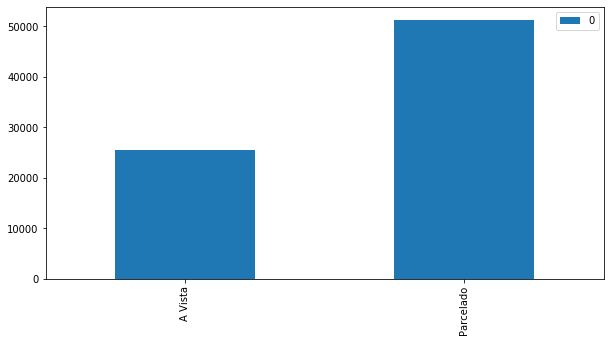

In [366]:
bar_chart('payment_installments')

    Pagamentos parcelados: 51338
    A vista: 25457

# AVALIAÇÃO DE EXPERIÊNCIA DE COMPRA

In [367]:
cols_df1 = ['order_id',
            'review_score']

cols_df2 = ['votes_before_estimate',
            'votes_delayed',
            'votes_low_quality',
            'votes_return',
            'votes_not_as_anounced',
            'votes_partial_delivery',
            'votes_other_order',
            'votes_satisfied',
            'most_voted_subclass',
            'most_voted_class']


reviews = pd.read_csv('olist_order_reviews_dataset.csv', usecols=cols_df1)
pedidos = pd.read_csv('olist_classified_public_dataset.csv', usecols=cols_df2)

In [368]:
pedidos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3584 entries, 0 to 3583
Data columns (total 10 columns):
votes_before_estimate     3584 non-null int64
votes_delayed             3584 non-null int64
votes_low_quality         3584 non-null int64
votes_return              3584 non-null int64
votes_not_as_anounced     3584 non-null int64
votes_partial_delivery    3584 non-null int64
votes_other_order         3584 non-null int64
votes_satisfied           3584 non-null int64
most_voted_subclass       3413 non-null object
most_voted_class          3413 non-null object
dtypes: int64(8), object(2)
memory usage: 252.1+ KB


In [369]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 2 columns):
order_id        100000 non-null object
review_score    100000 non-null int64
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


In [370]:
reviews.head()

,order_id,review_score
0,73fc7af87114b39712e6da79b0a377eb,4
1,a548910a1c6147796b98fdf73dbeba33,5
2,f9e4b658b201a9f2ecdecbb34bed034b,5
3,658677c97b385a9be170737859d3511b,5
4,8e6bfb81e283fa7e4f11123a3fb894f1,5


In [371]:
classific = reviews['review_score'].value_counts()
classific

5    57420
4    19200
1    11858
3     8287
2     3235
Name: review_score, dtype: int64

In [372]:
import plotly.graph_objects as go


cores = ['#33691e',  # verde
         '#006064',  # turquesa
         '#b71c1c',  # vermelho
         '#fbc02d',  # amarelo
         '#ff6f00']  # laranja

fig = go.Figure(go.Bar(x=classific.values,
                       y=classific.index,
                       orientation='h',
                       marker=dict(color=cores)))

layout_reviews = go.Layout(title='Reviews',
                           yaxis=dict(title='Nota (em estrelas)'),
                           bargap=.1)

fig_reviews = go.Figure(data=[trace_reviews],
                        layout=layout_reviews)


fig.show()

    Nivel de Satisfação:
    nota 5 - 57.42K
    nota 1 - 11.90K
    
    praticamente dois extremos

# PROCESSO DE COMPRA COM MAIS ATRASO

In [373]:
# Dados usados somente dos pedidos com problemas na entrega

mv_class = pedidos['most_voted_class']\
                .value_counts()

mv_class

satisfeito_com_pedido     1983
problemas_de_entrega       950
problemas_de_qualidade     480
Name: most_voted_class, dtype: int64

In [374]:
mv_subclass = pedidos['most_voted_subclass']\
                .value_counts()

mv_subclass

satisfeito                1491
antes_prazo                492
atrasado                   434
entrega_parcial            401
diferente_do_anunciado     163
baixa_qualidade            149
devolucao                  134
outro_entrega              115
outro_pedido                34
Name: most_voted_subclass, dtype: int64

    Atraso na entrega é o fator principal da falta de satisfação do cliente. 

In [375]:
import cufflinks as cf

# -As categorias mais e menos populares
# -Valores totais de venda (em reais) por categoria
# -Média de preço por categoria

In [376]:
categoria = pd.read_csv('olist_orders_dataset.csv')
categoria1= pd.read_csv('olist_public_dataset.csv')

In [377]:
categoria.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [378]:
categoria1.head()

,Unnamed: 0,id,order_status,order_products_value,order_freight_value,order_items_qty,order_sellers_qty,order_purchase_timestamp,order_aproved_at,order_estimated_delivery_date,...,customer_zip_code_prefix,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,0,1,delivered,79.00,17.80,1,1,2017-11-08 13:19:33.000000,2017-11-08 13:35:57.410228,2017-12-06 00:00:00.000000,...,728,papelaria,50,201,2,5,NaN,NaN,2017-11-24 00:00:00.000000,2017-11-25 11:18:22+00:00
1,1,2,delivered,119.90,27.16,1,1,2017-08-07 11:23:16.000000,2017-08-07 12:03:17.259618,2017-08-29 00:00:00.000000,...,892,market_place,50,511,3,5,NaN,NaN,2017-08-18 00:00:00.000000,2017-08-20 03:31:34+00:00
2,2,3,delivered,519.99,41.69,1,1,2018-03-22 02:29:42.000000,2018-03-22 03:09:06.550715,2018-04-19 00:00:00.000000,...,291,esporte_lazer,48,1156,2,1,NaN,produto veio quebrado e usado foi retirado de ...,2018-04-16 00:00:00.000000,2018-04-19 02:13:22+00:00
3,3,4,delivered,29.50,17.92,1,1,2017-09-14 21:51:28.000000,2017-09-14 22:08:10.626382,2017-10-06 00:00:00.000000,...,222,esporte_lazer,21,207,2,4,NaN,produto entregue como esperado,2017-10-04 00:00:00.000000,2017-10-04 20:07:28+00:00
4,4,5,delivered,26.77,23.11,1,1,2018-03-03 20:50:21.000000,2018-03-03 21:31:21.320960,2018-03-15 00:00:00.000000,...,40,cama_mesa_banho,41,451,1,5,NaN,produto de acordo com o pedido e entregue ante...,2018-03-07 00:00:00.000000,2018-03-08 00:23:26+00:00


In [379]:
# Soma das categorias

cols = ['order_id',
        'product_category_name',
        'order_products_value']

In [380]:
categorias_ok = categoria1['product_category_name']
print('Total: {} categorias'.format(categorias_ok.nunique()))

Total: 72 categorias


In [381]:
# 50% Das categorias mais vendidas

mais_vendidos = categorias_ok.value_counts().head(36)
mais_vendidos

cama_mesa_banho                                   10455
beleza_saude                                       7983
esporte_lazer                                      7823
moveis_decoracao                                   7821
relogios_presentes                                 7038
informatica_acessorios                             6289
utilidades_domesticas                              6230
ferramentas_jardim                                 4622
cool_stuff                                         4340
brinquedos                                         4049
perfumaria                                         3819
automotivo                                         3235
telefonia                                          3091
fashion_bolsas_e_acessorios                        2763
bebes                                              2368
papelaria                                          1997
pet_shop                                           1867
moveis_escritorio                               

In [382]:
# 50% das categorias menos vendidas

menos_vendidas = categorias_ok.value_counts().tail(32).sort_values()
menos_vendidas

seguros_e_servicos                      1
moda_oficiais_para_fas                  2
artes_e_artesanato                      5
cine_foto                               8
flores                                 10
construcao_ferramentas_ferramentas     10
cds_dvds_musicais                      13
fashion_roupa_infanto_juvenil          15
portateis_casa_forno_e_cafe            18
artigos_de_festas                      20
la_cuisine                             21
moveis_colchao_e_estofado              21
fraldas_higiene                        22
musica                                 22
casa_conforto_2                        23
livros_importados                      24
fashion_esporte                        41
moveis_quarto                          63
fashion_roupa_feminina                 66
dvds_blu_ray                           71
sinalizacao_e_seguranca                80
construcao_ferramentas_iluminacao      82
artes                                  84
industria_comercio_e_negocios     

# Somas de vendas por categoria

In [383]:
#Somas de vendas por categoria
vendas_somadas = categoria1.groupby('product_category_name')\
             ['order_products_value'].sum()
vendas_somadas

product_category_name
agro_industria_e_comercio     59078.64
alimentos                     16223.62
alimentos_bebidas             12150.83
artes                          5446.81
artes_e_artesanato              282.33
                               ...    
sinalizacao_e_seguranca       11474.05
tablets_impressao_imagem      10878.42
telefonia                    238788.29
telefonia_fixa                55573.62
utilidades_domesticas        615277.83
Name: order_products_value, Length: 72, dtype: float64

# Localizações

In [384]:
geo = pd.read_csv('olist_geolocation_dataset.csv')

In [385]:
geo.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP


In [386]:
geo['geolocation_zip_code_prefix'].value_counts().to_frame().describe()

,geolocation_zip_code_prefix
count,19015.000000
mean,52.598633
std,72.057907
min,1.000000
25%,10.000000
50%,29.000000
75%,66.500000
max,1146.000000


In [387]:
#norte do Brasil está a 5 graus 16 ′ 27,8 ″ de latitude N 
geo = geo[geo.geolocation_lat <= 5.27438888]
#ocidental está a 73 graus, 58 ′ 58,19 ″ W de Longitude
geo = geo[geo.geolocation_lng >= -73.98283055]
#O ponto mais ao sul está a 33 graus, 45 ′ 04,21 ″ S Latitude.
geo = geo[geo.geolocation_lat >= -33.75116944]
#O ponto mais oriental é 34 graus, 47 ′ 35.33 ″ W Longitude.
geo = geo[geo.geolocation_lng <=  -34.79314722]

    Trabalhando com CEP

In [388]:
import geopandas

In [389]:
geo['geolocation_zip_code_prefix'] = geo['geolocation_zip_code_prefix'].astype(int)

In [390]:
brazil = geo
agg_name = 'geolocation_zip_code_prefix'
brazil[agg_name].describe().to_frame()

,geolocation_zip_code_prefix
count,1.000121e+06
mean,3.657332e+04
std,3.054939e+04
min,1.001000e+03
25%,1.107500e+04
50%,2.653000e+04
75%,6.350400e+04
max,9.999000e+04


In [391]:
geo.loc[:5]

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP
5,1012,-23.547762,-46.635361,são paulo,SP


# Predição

In [392]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3584 entries, 0 to 3583
Data columns (total 34 columns):
Unnamed: 0                       3584 non-null int64
id                               3584 non-null int64
order_status                     0 non-null float64
order_products_value             3584 non-null float64
order_freight_value              3584 non-null float64
order_items_qty                  3584 non-null int64
order_sellers_qty                3584 non-null int64
order_purchase_timestamp         3584 non-null object
order_aproved_at                 3584 non-null object
order_estimated_delivery_date    3584 non-null object
order_delivered_customer_date    3467 non-null object
customer_city                    3584 non-null object
customer_state                   3584 non-null object
customer_zip_code_prefix         3584 non-null int64
product_category_name            3584 non-null object
product_name_lenght              3584 non-null int64
product_description_lenght       35

In [393]:
df.head()

,Unnamed: 0,id,order_status,order_products_value,order_freight_value,order_items_qty,order_sellers_qty,order_purchase_timestamp,order_aproved_at,order_estimated_delivery_date,...,votes_delayed,votes_low_quality,votes_return,votes_not_as_anounced,votes_partial_delivery,votes_other_delivery,votes_other_order,votes_satisfied,most_voted_subclass,most_voted_class
0,0,1,NaN,89.99,14.38,1,1,2017-08-30 11:41:01.000000,2017-08-30 11:55:08.970352,2017-09-21 00:00:00.000000,...,0,0,0,0,0,0,0,3,satisfeito,satisfeito_com_pedido
1,1,2,NaN,69.00,15.23,1,1,2017-09-26 09:13:36.000000,2017-09-26 09:28:10.922048,2017-10-24 00:00:00.000000,...,0,0,0,0,0,0,0,0,antes_prazo,satisfeito_com_pedido
2,2,3,NaN,99.80,15.86,2,4,2018-01-15 15:50:42.000000,2018-01-17 07:29:56.419769,2018-02-05 00:00:00.000000,...,0,0,0,0,3,0,0,0,entrega_parcial,problemas_de_entrega
3,3,4,NaN,87.00,12.74,1,1,2018-02-04 11:16:42.000000,2018-02-06 05:31:50.990164,2018-03-13 00:00:00.000000,...,3,0,0,0,0,0,0,0,atrasado,problemas_de_entrega
4,4,5,NaN,99.90,17.95,1,2,2017-12-07 11:58:42.000000,2017-12-08 02:36:49.587515,2018-01-03 00:00:00.000000,...,0,0,0,0,3,0,0,0,entrega_parcial,problemas_de_entrega


In [394]:
df = pd.read_csv('olist_classified_public_dataset.csv')

In [395]:
df.head()

,Unnamed: 0,id,order_status,order_products_value,order_freight_value,order_items_qty,order_sellers_qty,order_purchase_timestamp,order_aproved_at,order_estimated_delivery_date,...,votes_delayed,votes_low_quality,votes_return,votes_not_as_anounced,votes_partial_delivery,votes_other_delivery,votes_other_order,votes_satisfied,most_voted_subclass,most_voted_class
0,0,1,delivered,89.99,14.38,1,1,2017-08-30 11:41:01.000000,2017-08-30 11:55:08.970352,2017-09-21 00:00:00.000000,...,0,0,0,0,0,0,0,3,satisfeito,satisfeito_com_pedido
1,1,2,delivered,69.00,15.23,1,1,2017-09-26 09:13:36.000000,2017-09-26 09:28:10.922048,2017-10-24 00:00:00.000000,...,0,0,0,0,0,0,0,0,antes_prazo,satisfeito_com_pedido
2,2,3,delivered,99.80,15.86,2,4,2018-01-15 15:50:42.000000,2018-01-17 07:29:56.419769,2018-02-05 00:00:00.000000,...,0,0,0,0,3,0,0,0,entrega_parcial,problemas_de_entrega
3,3,4,delivered,87.00,12.74,1,1,2018-02-04 11:16:42.000000,2018-02-06 05:31:50.990164,2018-03-13 00:00:00.000000,...,3,0,0,0,0,0,0,0,atrasado,problemas_de_entrega
4,4,5,delivered,99.90,17.95,1,2,2017-12-07 11:58:42.000000,2017-12-08 02:36:49.587515,2018-01-03 00:00:00.000000,...,0,0,0,0,3,0,0,0,entrega_parcial,problemas_de_entrega


In [396]:
df['order_status'].value_counts()

delivered     3467
shipped         48
canceled        25
invoiced        24
processing      20
Name: order_status, dtype: int64

In [397]:
nonvenda: 0
venda: 1
pagar: 2
processando: 3
enviado: 4

In [398]:
train_test_data = [df, categoria1]

title_mapping = {"canceled": 0, "delivered": 1, "invoiced": 2, 
                 "processing": 3, "shipped": 4}
for dataset in train_test_data:
    dataset['order_status'] = dataset['order_status'].map(title_mapping) # Alterando Os Titulos para NUMEROS

In [399]:
df['order_status'].value_counts()

1    3467
4      48
0      25
2      24
3      20
Name: order_status, dtype: int64

In [400]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

(3584, 1) (3584, 1)


Text(0, 0.5, 'Venda')

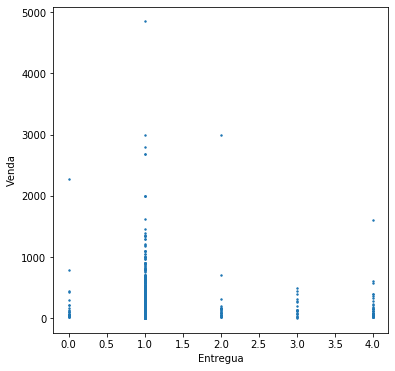

In [404]:
x = df['order_status'].values.reshape(-1, 1)
y = df['order_products_value'].values.reshape(-1, 1)

print(x.shape, y.shape)

plt.figure(figsize=(6, 6))
plt.scatter(x, y, s=2)
plt.xlabel('Entregua')
plt.ylabel('Venda')

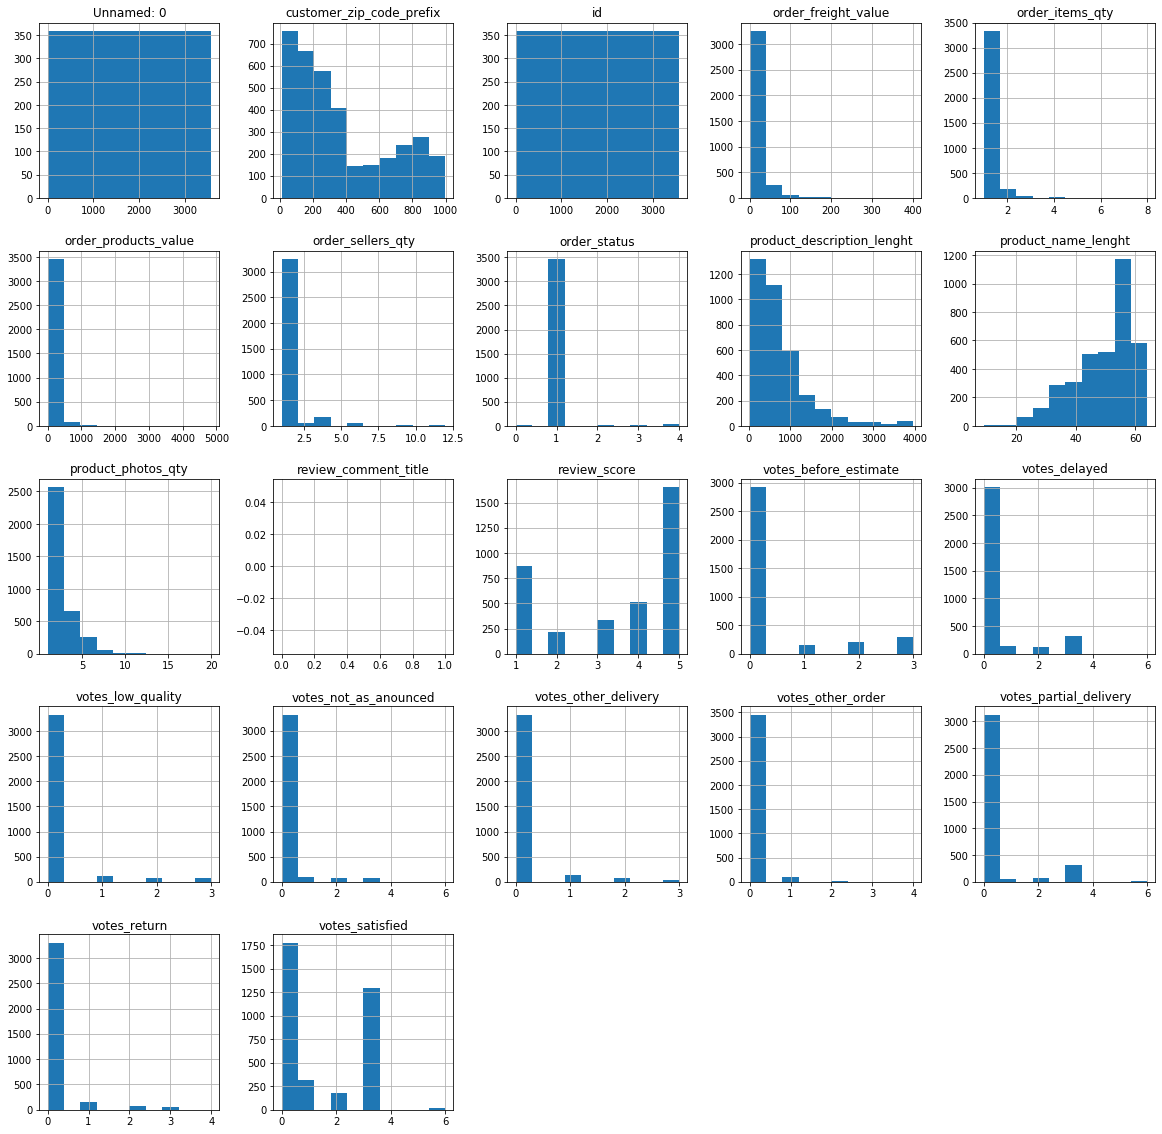

In [405]:
df.hist(figsize=(20,20))
plt.show()

In [406]:
def correlation(x, y):    
    x1 = (x - np.mean(x))
    y1 = (y - np.mean(y))
    
    num = np.sum(x1*y1)
    div = np.sqrt(np.sum(x1**2) * np.sum(y1**2))
    return num/div

In [407]:
class MyLinearRegression():
    def __init__(self):
        self.b0 = 0.0
        self.b1 = 0.0
    
    def fit(self, x, y):
        self.b1 = correlation(x, y) * np.std(y) / np.std(x)
        self.b0 = np.mean(y) - (self.b1 * np.mean(x))
    
    def predict(self, x):
        return self.b0 + self.b1*x

b0: 123.05336261813179 b1: 9.693514302260594


Text(0, 0.5, 'Venda')

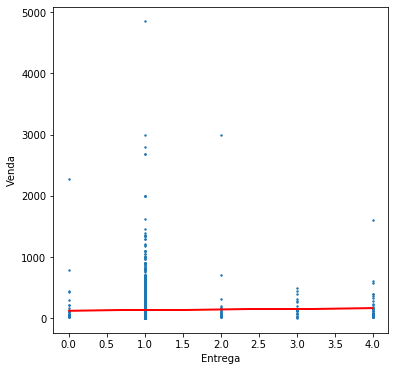

In [409]:
reg = MyLinearRegression()
reg.fit(x, y)

print('b0: {} b1: {}'.format(reg.b0, reg.b1))

plt.figure(figsize=(6, 6))
plt.scatter(x, y, s=2)
plt.plot(x, reg.predict(x), c='red')
plt.xlabel('Entrega')
plt.ylabel('Venda')